In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pyEDM as edm


def load_kinematics_data(file_path='kinematics11.h5'):
    """
    Loads velocity and acceleration data from an HDF5 file.]
    """
    print(f"Loading data from {file_path}...")
    with h5py.File(file_path, 'r') as hf:
        pos = hf['rel'][:]
        vel = hf['rel_v'][:]
        acc = hf['rel_a'][:]
    print("Data loaded successfully.")
    return pos, vel, acc


def plot_rho_colormaps(emb_df: pd.DataFrame):
    if emb_df is None or emb_df.empty:
        print("Input DataFrame is empty. Cannot generate plots.")
        return

    print("\nGenerating colormaps for forecast skill (rho)...")
    
    # Reshape the data from a wide to a long format for easier plotting
    id_vars = ['E']
    value_vars = [col for col in emb_df.columns if col.startswith('rho_')]
    
    if not value_vars:
        print("No 'rho' columns found in the DataFrame to plot.")
        return

    long_df = pd.melt(emb_df, id_vars=id_vars, value_vars=value_vars,
                      var_name='params', value_name='rho')
    
    # Extract tau and tp from the 'params' column (e.g., from 'rho_tau1_tp2')
    try:
        long_df['tau'] = [int(s[7:s.find('tp')-1]) for s in long_df['params'].to_list()]
        long_df['tp'] = [int(s[s.find('tp')+2:]) for s in long_df['params'].to_list()]
    except Exception as e:
        print(f"Could not parse 'tau' and 'tp' from column names. Error: {e}")
        return

    # Create a separate plot for each unique Tp value
    unique_tp = sorted(long_df['tp'].unique())
    
    fig, axes = plt.subplots(1, len(unique_tp), figsize=(6 * len(unique_tp), 5), squeeze=False)
    
    for i, tp in enumerate(unique_tp):
        ax = axes[0, i]
        df_for_plot = long_df[long_df['tp'] == tp]
        
        # Pivot the data to create a matrix for the heatmap
        pivot_df = df_for_plot.pivot(index='E', columns='tau', values='rho')
        
        im = ax.imshow(pivot_df, cmap='viridis', aspect='auto', origin='lower',
                       extent=[pivot_df.columns.min()-0.5, pivot_df.columns.max()+0.5, 
                               pivot_df.index.min()-0.5, pivot_df.index.max()+0.5])
        
        fig.colorbar(im, ax=ax, label='Forecast Skill (rho)')
        ax.set_title(f'Forecast Skill (rho) for Tp = {tp}')
        ax.set_xlabel('Time Delay (tau)')
        ax.set_ylabel('Embedding Dimension (E)')
        
        ax.set_xticks(pivot_df.columns)
        ax.set_yticks(pivot_df.index)

    plt.tight_layout()
    plt.show()
    print("Colormaps displayed.")


def plot_rho_colormaps_by_col(emb_df: pd.DataFrame):
    """
    Generates 2x6 colormap grids for position, velocity, and acceleration data.
    This version avoids regular expressions.
    """
    print("\nGenerating colormaps for forecast skill (rho)...")

    data_types = ['pos', 'vel', 'acc']
    
    for data_type in data_types:
        fig, axes = plt.subplots(2, 6, figsize=(20, 7))
        fig.suptitle(f'Forecast Skill (rho) for {data_type.capitalize()} Data', fontsize=12)
        
        im = None
        
        for i in range(12):
            row, col = i // 6, i % 6
            ax = axes[row, col]
            
            # Hardcode the channel name prefix we're looking for
            channel_name = f"{data_type}_ch{i}"
            col_prefix = f"rho_{channel_name}_tau"

            # Select all columns related to this specific channel
            channel_cols = [c for c in emb_df.columns if c.startswith(col_prefix)]
            
            if not channel_cols:
                ax.set_title(f'{channel_name} (No data)')
                continue

            # Create a temporary DataFrame and melt it to a long format
            df_subset = emb_df[['E'] + channel_cols]
            df_long = pd.melt(df_subset, id_vars=['E'], var_name='params', value_name='rho')
            
            # Extract tau by splitting the string, avoiding regex
            df_long['tau'] = df_long['params'].str.split('tau').str[1].astype(int)

            # Pivot the data to create a matrix for the heatmap
            pivot_df = df_long.pivot(index='E', columns='tau', values='rho')
            pivot_df.sort_index(axis=1, inplace=True) # Sort columns by tau value
            
            # Plot the heatmap
            im = ax.imshow(pivot_df, cmap='viridis', aspect='auto', origin='lower',
                           extent=[pivot_df.columns.min()-0.5, pivot_df.columns.max()+0.5, 
                                   pivot_df.index.min()-0.5, pivot_df.index.max()+0.5])
            
            ax.set_title(channel_name)
            ax.set_xticks(pivot_df.columns)
            ax.set_yticks(emb_df['E'].unique())

        # Common labels and a single colorbar for the figure
        fig.text(0.5, 0.02, 'Time Delay (tau)', ha='center', va='center', fontsize=12)
        fig.text(0.08, 0.5, 'Embedding Dimension (E)', ha='center', va='center', rotation='vertical', fontsize=12)
        if im:
            fig.colorbar(im, ax=axes.ravel().tolist(), label='Forecast Skill (rho)', pad=0.01)

        plt.tight_layout(rect=[0.09, 0.03, 1, 0.95])
        
    plt.show()
    print("Colormaps displayed.")


Loading data from kinematics11.h5...
Data loaded successfully.
pos_df.shape=(4000, 12)
vel_df.shape=(4000, 12)
acc_df.shape=(4000, 12)
all_df.shape=(4000, 36)


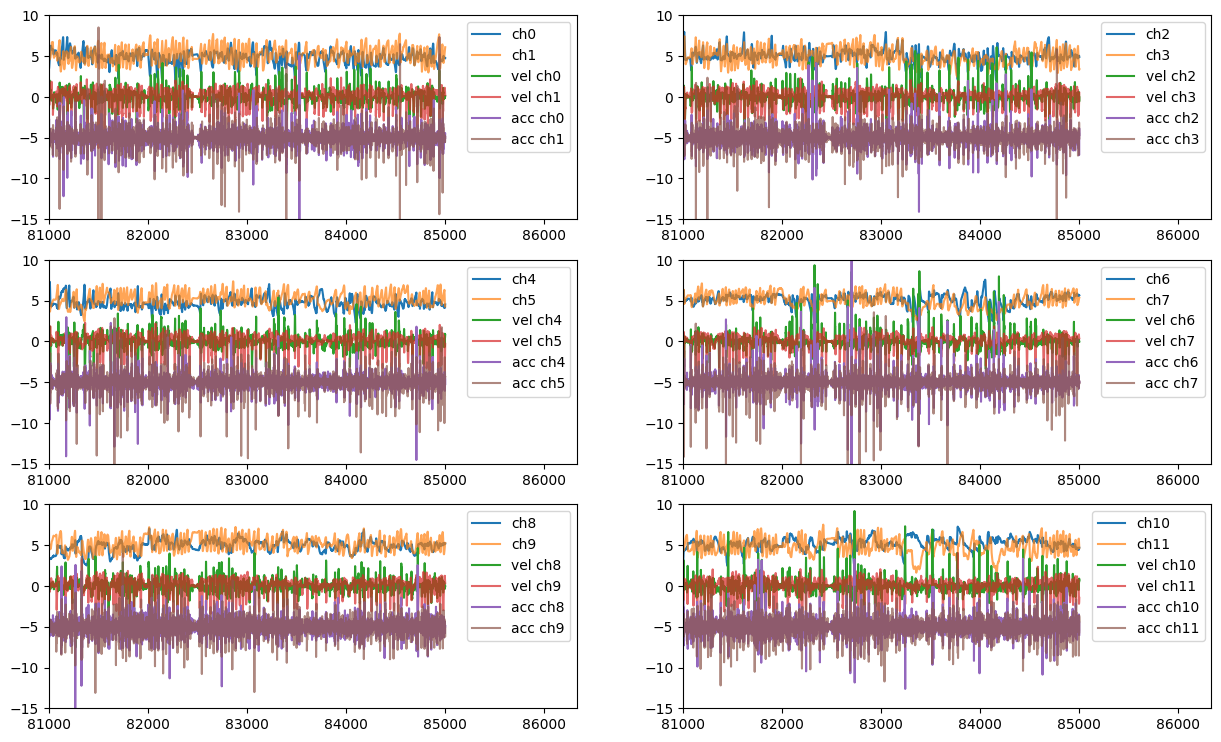

In [ ]:
pos, vel, acc = load_kinematics_data()
pos = (pos - pos.mean(axis=0)) / pos.std(axis=0)
vel = (vel - vel.mean(axis=0)) / vel.std(axis=0)
acc = (acc - acc.mean(axis=0)) / acc.std(axis=0)

pos_df = pd.DataFrame(pos, columns=[f"pos_ch{ch}" for ch in range(pos.shape[1])])
vel_df = pd.DataFrame(vel, columns=[f"vel_ch{ch}" for ch in range(vel.shape[1])])
acc_df = pd.DataFrame(acc, columns=[f"acc_ch{ch}" for ch in range(acc.shape[1])])

ch = [(0,1), (2,3), (4,5), (6,7), (8,9), (10,11)]
st = 81000
le = 4000
step = 1
pos_df = pos_df.iloc[st:st+le:step]
vel_df = vel_df.iloc[st:st+le:step]
acc_df = acc_df.iloc[st:st+le:step]
all_df = pd.concat([pos_df, vel_df, acc_df], axis=1)

print(f"{pos_df.shape=}")
print(f"{vel_df.shape=}")
print(f"{acc_df.shape=}")
print(f"{all_df.shape=}")

fig, ax = plt.subplots(3,2, figsize=(15,9))
for ch_i, ax_i in zip(ch, ax.flatten()):
    ax_i.plot(all_df[f"pos_ch{ch_i[0]}"] + 5, label=f"ch{ch_i[0]}")
    ax_i.plot(all_df[f"pos_ch{ch_i[1]}"] + 5, alpha=0.7, label=f"ch{ch_i[1]}")
    ax_i.plot(all_df[f"vel_ch{ch_i[0]}"], label=f"vel ch{ch_i[0]}")
    ax_i.plot(all_df[f"vel_ch{ch_i[1]}"], alpha=0.7, label=f"vel ch{ch_i[1]}")
    ax_i.plot(all_df[f"acc_ch{ch_i[0]}"] - 5, label=f"acc ch{ch_i[0]}")
    ax_i.plot(all_df[f"acc_ch{ch_i[1]}"] - 5, alpha=0.7, label=f"acc ch{ch_i[1]}")
    ax_i.set_ylim(-15, 10)
    ax_i.set_xlim(st, st + le + le // 3)
    ax_i.legend()
plt.show()

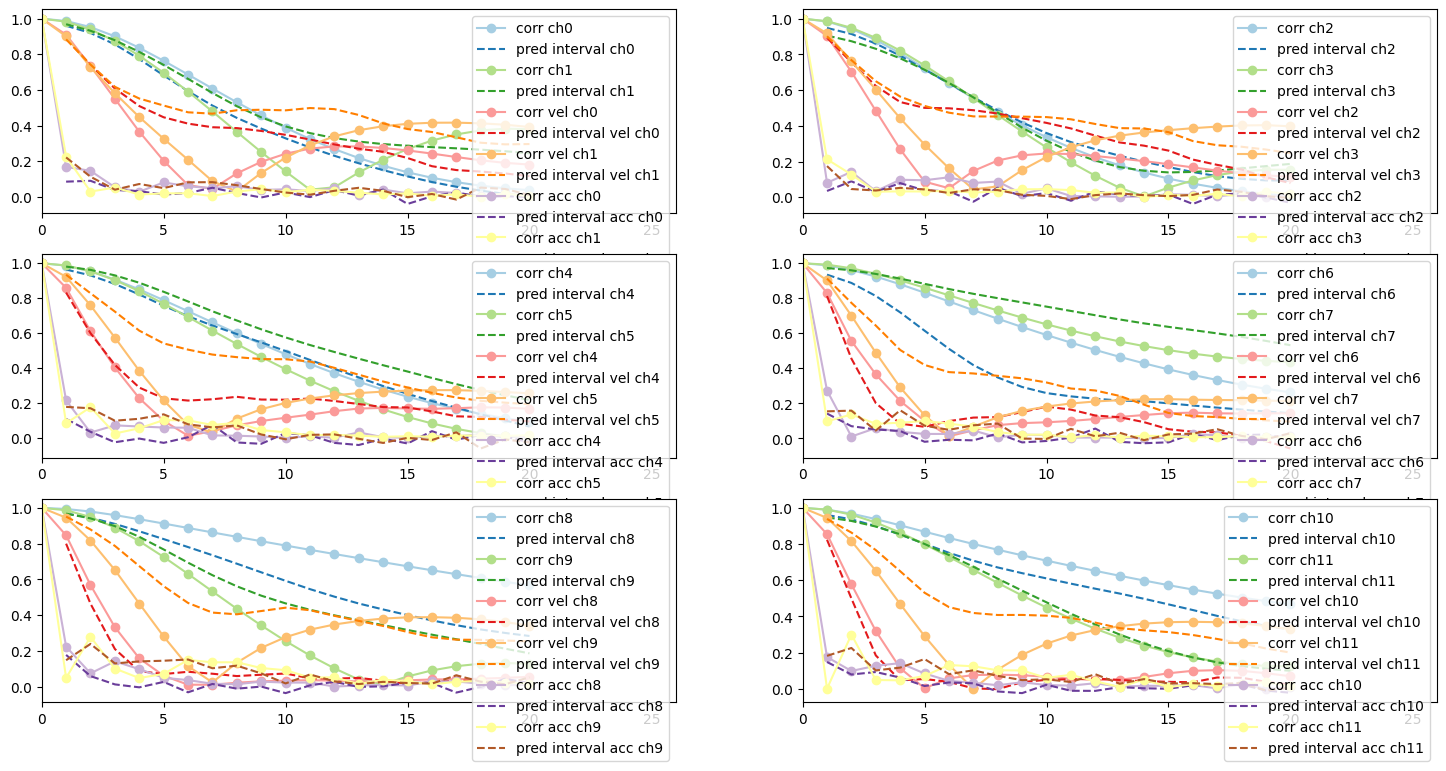

In [ ]:
import seaborn as sns
c = sns.color_palette("Paired")

nlags = 20
fig, ax = plt.subplots(3,2, figsize=(18,9))
for ch_i, ax_i in zip(ch, ax.flatten()):
    acf_ = acf(all_df[f"pos_ch{ch_i[0]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr ch{ch_i[0]}", color=c[0])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"pos_ch{ch_i[0]}",
        target = f"pos_ch{ch_i[0]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval ch{ch_i[0]}", color=c[1])

    acf_ = acf(all_df[f"pos_ch{ch_i[1]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr ch{ch_i[1]}", color=c[2])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"pos_ch{ch_i[1]}",
        target = f"pos_ch{ch_i[1]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval ch{ch_i[1]}", color=c[3])

    acf_ = acf(all_df[f"vel_ch{ch_i[0]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr vel ch{ch_i[0]}", color=c[4])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"vel_ch{ch_i[0]}",
        target = f"vel_ch{ch_i[0]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval vel ch{ch_i[0]}", color=c[5])

    acf_ = acf(all_df[f"vel_ch{ch_i[1]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr vel ch{ch_i[1]}", color=c[6])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"vel_ch{ch_i[1]}",
        target = f"vel_ch{ch_i[1]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval vel ch{ch_i[1]}", color=c[7])

    acf_ = acf(all_df[f"acc_ch{ch_i[0]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr acc ch{ch_i[0]}", color=c[8])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"acc_ch{ch_i[0]}",
        target = f"acc_ch{ch_i[0]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval acc ch{ch_i[0]}", color=c[9])

    acf_ = acf(all_df[f"acc_ch{ch_i[1]}"], nlags=nlags)
    ax_i.plot(np.abs(acf_), "o-", label=f"corr acc ch{ch_i[1]}", color=c[10])
    pred_interval_df = edm.PredictInterval(
        dataFrame = all_df,
        columns = f"acc_ch{ch_i[1]}",
        target = f"acc_ch{ch_i[1]}",
        lib = [1, le//2],
        pred = [le//2, le],
        maxTp = nlags,
        E = 6,
        tau = -4,
        exclusionRadius = 25,
        showPlot = False, 
        validLib = [],
        numProcess = 4,
    )
    ax_i.plot(pred_interval_df["Tp"], pred_interval_df["rho"], "--", label=f"pred interval acc ch{ch_i[1]}", color=c[11])

    ax_i.set_xlim(0, nlags + nlags//3)
    ax_i.legend()

### 3. Use pyEDM to find optimal embedding parameters for velocity

Note: Using a subset of the data for efficiency, as pyEDM can be slow.

In [ ]:
tp = 6
emb_df = None
for col in all_df.columns:
    for tau in range(-2, -9, -1):
        print(f"{col=}, {tau=}")
        tmp_df = edm.EmbedDimension(
            dataFrame = all_df,
            columns = col,
            target = col,
            lib = [1, le//2],
            pred = [le//2, le],
            maxE = 10,
            Tp = tp,
            tau = tau,
            exclusionRadius = 25,
            showPlot = False,
            validLib = [],
            numProcess = 4,
        )
        rho_col_name = f'rho_{col}_tau{tau}'
        tmp_df.rename(columns={'rho': rho_col_name}, inplace=True)
        if emb_df is None:
            emb_df = tmp_df
        else:
            emb_df = pd.merge(emb_df, tmp_df[['E', rho_col_name]], on='E', how='outer')
        
print(f"\n{emb_df}")
plot_rho_colormaps(emb_df)

col='pos_ch0', tau=-2
col='pos_ch0', tau=-3
col='pos_ch0', tau=-4
col='pos_ch0', tau=-5
col='pos_ch0', tau=-6
col='pos_ch0', tau=-7
col='pos_ch0', tau=-8
col='pos_ch1', tau=-2
col='pos_ch1', tau=-3
col='pos_ch1', tau=-4
col='pos_ch1', tau=-5
col='pos_ch1', tau=-6
col='pos_ch1', tau=-7
col='pos_ch1', tau=-8
col='pos_ch2', tau=-2
col='pos_ch2', tau=-3
col='pos_ch2', tau=-4
col='pos_ch2', tau=-5
col='pos_ch2', tau=-6
col='pos_ch2', tau=-7
col='pos_ch2', tau=-8
col='pos_ch3', tau=-2
col='pos_ch3', tau=-3
col='pos_ch3', tau=-4
col='pos_ch3', tau=-5
col='pos_ch3', tau=-6
col='pos_ch3', tau=-7
col='pos_ch3', tau=-8
col='pos_ch4', tau=-2
col='pos_ch4', tau=-3
col='pos_ch4', tau=-4
col='pos_ch4', tau=-5
col='pos_ch4', tau=-6
col='pos_ch4', tau=-7
col='pos_ch4', tau=-8
col='pos_ch5', tau=-2
col='pos_ch5', tau=-3
col='pos_ch5', tau=-4
col='pos_ch5', tau=-5
col='pos_ch5', tau=-6
col='pos_ch5', tau=-7
col='pos_ch5', tau=-8
col='pos_ch6', tau=-2
col='pos_ch6', tau=-3
col='pos_ch6', tau=-4
col='pos_c

tau=-1
tau=-2
tau=-3
tau=-4
tau=-5
tau=-6

    E  rho_tau-1_tp6  rho_tau-2_tp6  rho_tau-3_tp6  rho_tau-4_tp6  \
0   1      -0.009109      -0.009109      -0.009109      -0.009109   
1   2       0.102946       0.092721       0.171454       0.191583   
2   3       0.107145       0.206840       0.199610       0.264885   
3   4       0.188507       0.234968       0.285452       0.280631   
4   5       0.218005       0.297404       0.297615       0.339972   
5   6       0.251469       0.316019       0.318734       0.375963   
6   7       0.259674       0.296449       0.326972       0.335650   
7   8       0.272283       0.298663       0.340643       0.322522   
8   9       0.292257       0.331823       0.323710       0.258300   
9  10       0.303667       0.348850       0.337085       0.256790   

   rho_tau-5_tp6  rho_tau-6_tp6  
0      -0.009109      -0.009109  
1       0.234695       0.205726  
2       0.258655       0.269451  
3       0.307712       0.331588  
4       0.335927       0.27

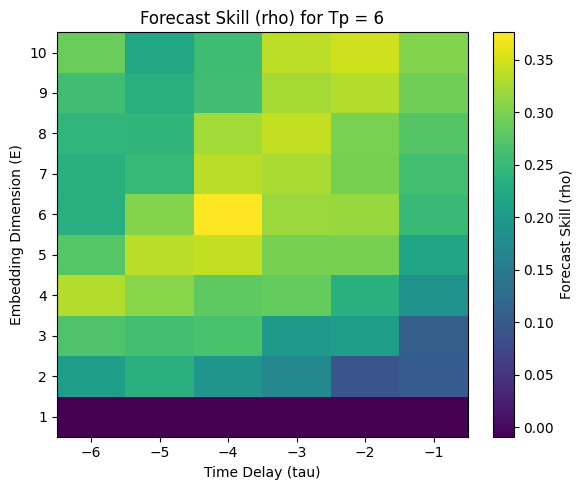

Colormaps displayed.


In [ ]:
emb_df = None
for tau in range(-1, -7, -1):
    print(f"{tau=}")
    for tp in range(6, 7):
        tmp_df = edm.EmbedDimension(
            dataFrame = vel_df,
            columns = f"ch{ch}",
            target = f"ch{ch}",
            lib = [1, len(vel_df)//2],
            pred = [len(vel_df)//2, len(vel_df)],
            maxE = 10,
            Tp = tp,
            tau = tau,
            exclusionRadius = 0,
            showPlot = False,
            validLib = [],
            numProcess = 4,
        )
        rho_col_name = f'rho_tau{tau}_tp{tp}'
        tmp_df.rename(columns={'rho': rho_col_name}, inplace=True)
        if emb_df is None:
            emb_df = tmp_df
        else:
            emb_df = pd.merge(emb_df, tmp_df[['E', rho_col_name]], on='E', how='outer')
        
print(f"\n{emb_df}")
plot_rho_colormaps(emb_df)

In [ ]:
e = 6
tp = 6
tau = 4
exclusionRadius = e * tau + 1
lib = [le//8, le, le//8]
sample = 3

cols = vel_df.columns
cm_matrix = np.zeros((len(cols), len(cols)))
for i, ch_in in enumerate(cols):
    for j, ch_tar in enumerate(cols[i:]):
        cm = edm.CCM(
            dataFrame = vel_df,
            columns = ch_in,
            target = ch_tar,
            E = e,
            Tp = tp,
            knn = 0,
            tau = -tau,
            exclusionRadius = exclusionRadius,
            libSizes = lib,
            sample = sample,
            seed = 0,
            verbose = False,
            showPlot = False,
        )

        print(f"{ch_in} -> {ch_tar}")
        print(cm, "\n")

        cm_matrix[i, i + j] = cm.loc[3, f"ch{i}:ch{i+j}"]
        cm_matrix[i + j, i] = cm.loc[3, f"ch{i+j}:ch{i}"]
        print(cm_matrix, "\n")

ch0 -> ch0
   LibSize   ch0:ch0
0      250  0.471903
1      500  0.495653
2      750  0.536260
3     1000  0.537940
4     1250  0.512357
5     1500  0.485183
6     1750  0.461230
7     2000  0.445410 

[[0.53794 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.     ]
 [0.      0.      0.      0.  

In [ ]:
np.save(f"ccm_matrix_{le}_E{e}_Tp{tp}_tau{tau}.npy", cm_matrix)

In [ ]:
le = 24000
e = 7
tp = 4
tau = 3
cm_matrix = np.load(f"ccm_matrix_{le}_E{e}_Tp{tp}_tau{tau}.npy")

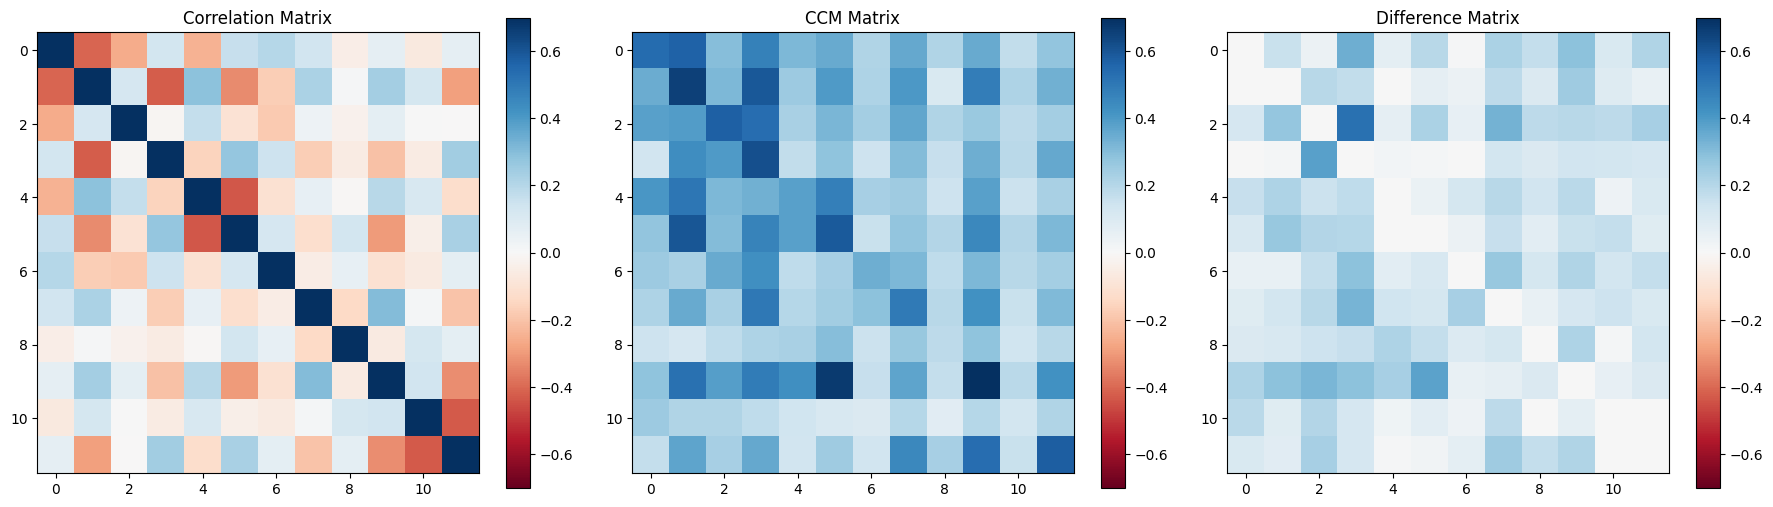

In [ ]:
corr_matrix = vel_df.corr().abs()
diff = cm_matrix - corr_matrix
diff[diff < 0] = 0

fig, ax = plt.subplots(1,3, figsize=(18,5))
im0 = ax[0].imshow(vel_df.corr(), cmap='RdBu', aspect='equal', origin='upper', vmin=-0.7, vmax=0.7)
ax[0].set_title('Correlation Matrix')
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(cm_matrix, cmap='RdBu', aspect='equal', origin='upper', vmin=-0.7, vmax=0.7)
ax[1].set_title('CCM Matrix')
fig.colorbar(im1, ax=ax[1])
im2 = ax[2].imshow(diff, cmap='RdBu', aspect='equal', origin='upper', vmin=-0.7, vmax=0.7)
ax[2].set_title('Difference Matrix')
fig.colorbar(im2, ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
# df = EDM.PredictNonlinear( dataFrame = vel,
#                             columns = "C0", target = "C0",
#                             lib = [1, len(vel)//2], pred = [len(vel)//2, len(vel)], E = 4,
#                             Tp = 4, knn = 0, tau = -1,
#                             validLib = [], numProcess = 4 )

# S = EDM.Simplex( dataFrame = EDM.sampleData[ "block_3sp" ],
#                     columns = "x_t y_t z_t", target = "x_t",
#                     lib = [1, 99], pred = [100, 198], E = 3, Tp = 1,
#                     knn = 0, tau = -1, exclusionRadius = 0,
#                     embedded = True, showPlot = True, validLib = [] )

# S = EDM.Simplex( dataFrame = EDM.sampleData[ "block_3sp" ],
#                     columns = "x_t", target = "x_t",
#                     lib = [1, 99], pred = [100, 198], E = 3, Tp = 1,
#                     knn = 0, tau = -1, exclusionRadius = 0,
#                     embedded = False, showPlot = True, validLib = [] )

# M = EDM.Multiview( dataFrame = EDM.sampleData[ "block_3sp" ],
#                     columns = ["x_t", "y_t", "z_t"], target = "x_t",
#                     lib = [1, 100], pred = [101, 198],
#                     D = 0, E = 3, Tp = 1, knn = 0, tau = -1,
#                     multiview = 0, exclusionRadius = 0,
#                     trainLib = False, excludeTarget = False,
#                     numProcess = 4, showPlot = True )

# S = EDM.SMap( dataFrame = EDM.sampleData[ "circle" ], 
#                 columns = ["x", "y"], target = "x",
#                 lib = [1, 100], pred = [101, 198],
#                 E = 2, Tp = 1, knn = 0, tau = -1,
#                 theta = 4, exclusionRadius = 0,
#                 solver = None, embedded = True, validLib = [] )